# Leveraging LLMs for Real-Time Decision Making in Calamities: Analyzing the HarveyTweet Dataset

## Table of Contents

[Introduction](#introduction)
* [Brief Introduction to Toolbox and Python API](#Brief-Introduction-to-Toolbox-and-Python-API)
* [Introduction to workflow](#Introduction-to-workflow)

[Imports](#Imports)\
[Prompt Engineering](#Prompt-Engineering)\
[Esri Model Definition(EMD) file](#Esri-Model-Definition(EMD)-file)\
[Anatomy of the Extension Function](#Anatomy-of-the-Extension-Function)
* [Define the ```__init__``` function](#Define-the-__init__-function)
* [Define the ```getParameterInfo``` function](#define-the-getconfiguration-function)
* [Define the ```initialize``` function](#define-the-initialize-function)
* [Define the ```getConfiguration``` function](#define-the-getparameterinfo-function)
* [Define the ```predict``` function](#define-the-predict-function)

[Complete NLP Function](#Complete-NLP-Function)\
[Create Custom ESRI Deep Learning Package (.dlpk)](#Custom-Deep-Learning-Package-Model-File)\
[ESRI Deep Learning Package (.dlpk) in arcgis.learn API](#Using-the-Custom-.dlpk-with-the-arcgis.learn-API)\
[Tool Interface](#tool-interface)\
[Sample Input Table](#Sample-Input-Table)\
[Sample Output Table](#Sample-Output-Table)\
[Conclusion](#conclusion)

## Introduction

### Brief Introduction to Toolbox and Python API

The Text Analysis toolset in the **GeoAI toolbox** provides a set of tools for various text processing tasks, including _text classification, entity extraction, and text translation_. The natural language processing (NLP) models created using these tools are built on language model backbones like BERT, RoBERTa, T5 and large language models (LLMs) Mistral, to ensure high-performance text analysis.

However, what if you come across a **Text model** or **LLM** that is not yet a part of the learn module, and you want to use it from its library or its open-source code repository? What if you have tune your own **text model** for a task such as standardizing addresses, conducting sentiment analysis, or extracting custom entities or relationships not currently supported by the Text Analysis toolset? How would you use it inside the **ArcGIS Pro**?

To meet these needs, you can integrate ArcGIS with external third-party language models. This includes open source LLMs as well as cloud-hosted, commercial LLMs accessed using a web API. Keep in mind that if you are using a web hosted LLM, the data that you are processing will be sent to the LLM provider for processing. Python developers can author a custom NLP function to integrate with external models and package their model as an ESRI Deep Learning Package (.dlpk) file for use with the following tools:

1. [Classify Text Using Deep Learning (GeoAI)](https://pro.arcgis.com/en/pro-app/latest/tool-reference/geoai/classify-text-using-deep-learning.htm)
2. [Extract Entities Using Deep Learning (GeoAI)](https://pro.arcgis.com/en/pro-app/latest/tool-reference/geoai/extract-entities-using-deep-learning.htm)
3. [Transform Text Using Deep Learning (GeoAI)](https://pro.arcgis.com/en/pro-app/latest/tool-reference/geoai/transform-text-using-deep-learning.htm)

ESRI Deep Learning Package (.dlpk) file of the custom NLP function is also supported using `arcgis.learn` Python API. It supports third party custom models through various classes, including `TextClassifier`, `EntityRecognizer`, and `SequenceToSequence`.


This document presents a use case where a hosted commercial LLM has been utilized to perform an address standardization task. It provides a step-by-step guide detailing the various components of the **NLP Function** and explains how to create a ESRI Deep Learning Package (.dlpk) file using the NLP function. We will also achieve the same task using the **Python API**.


### Introduction to workflow

This project aims to showcase the capabilities of **Large Language Models (LLMs)** for making informed decisions during emergencies. While traditional approaches often involve post-hoc data analysis, our focus is on leveraging live data streaming and near-real-time analysis to deliver targeted relief to affected individuals. 

 We utilized a dataset of 1,000 annotated tweets, categorized into various classes such as street addresses, local organizations, and more. By employing **On-Prem Llama-3**, we were able to identify locations and classify the tweets into relevant categories such as **Public service, Health, and others**. This work also introduces the concept of **model extension** within the Text Tools and API.

 **Intended Audience:**  
  Analysts and Extension Model Developers

 **Dataset:**  
  [HarveyTweet Dataset](https://arxiv.org/pdf/2009.12914)

 **Backbone:**  
  Llama-3

 **Capabilities Demonstrated:**  
  - Prompt Engineering Techniques
  - Out-of-the-Box LLM Utilization
  - Minimal Annotation Requirements
  - Comparable Accuracy to Traditional Methods
  - Integration of Custom Models within ArcGIS Pro's Text Tool and API


## Imports

In [ ]:
import re
import json
from string import Template
from arcgis.features import FeatureSet
from transformers import AutoModelForCausalLM, AutoTokenizer

## Prompt Engineering

To execute the specified task—identifying key information from tweets—we will design a **system prompt** to guide the model’s overall behavior and set necessary guardrails. Additionally, a **user prompt** will be implemented to define the task with greater precision.

In [ ]:

SYSTEM_PROMPT = """
You are a Text classifier. You need to tag in following classes $classes. Your output must be devoid of any biases.
You must not generate any explanation or notes for your response. Just generated the class which you thing best fit for the tweets.  
Your output must be devoid of any biases.
        
        You must adhere the below JSON schema while generating the output. Always place your output between << and >>. If there are multiple classes, then place it as <<label1, label2>>. 
        
        This is the representative example: 
        "input": $sentence
        "output": $answer
        $user_prompt
"""

USER_PROMPT = """
Classify all the input sentences from the text field into the classes present in the label field. Don't make up your own labels. You need to classify into single class.
"""

## Esri Model Definition(EMD) file 

The ESRI Model Definition (.emd) file will include both required and optional keys to facilitate model execution. To run **Classify Text Using Deep Learning (GeoAI)** Tool, we need to supply the `InferenceFunction`, `ModelType` and `OutputField`. 

1. `InferenceFunction`: Name of the module that contains the definition of NLP function
2. `ModelType`: Defines the type of task. For **Classify Text Using Deep Learning (GeoAI)** Tool it will be `TextClassifier`
3. `OutputField`: Name of the field in which contains the output

Other keys are prerogative of the Model extension author. In this case, we took liberty to state the prompt `few-shot prompting` related information - `examples` and `prompt`. We will utilize this information to construct a clear and effective prompt for the task.

In [ ]:
{
    "InferenceFunction": "MyTextClassifier.py",
    "Label": [
      "Health emergency",
      "Public service failures",
      "Others"
    ],
    "prompt": "Classify all the input sentences from the text field into the classes present in the label field. Don't make up your own labels. You need to classify into single class.",
    "examples": [
      [
        "Texas Harvey - We need mandatory evacuation for Pecan Grove .",
        "Health emergency"
      ],
      [
        "Rockport about to get hit by 130 mph winds after several building collapsed , many injured , and high school partial â€¦",
        "Health emergency"
      ],
      [
        "* * * PLS SHARE : Houston police need socks , undershirts , underwear at 1602 State St ( Union Hall ) Harvey HoustonFlood",
        "Public service failuers"
      ],
      [
        "1253mm of rain recorded SE of Houston as a result of HurricaneHarvey . To put that into perspective , the ANNUAL ave â€¦",
        "Others"
      ]
    ],
    "ModelType": "TextClassifier",
    "ModelName": "TextClassifier",
    "OutputField": "class_3"
  }

## Anatomy of the Extension Function

Model extension requires the process be wrapped in a class with the following functions implemented:

- `__init__`

- `getParameterInfo`

- `initialize`

- `getConfiguration`

- `predict`

Let’s create a custom extension model to classify input tweets into the categories: **Health Emergency, Public Service Failures, and Other**.

### Define the ```__init__``` function

In [1]:
def __init__(self, **kwargs):
    self.description = "Tweet classification into pre-defined classes using Llama-3 model"
    self.name = "Tweet classifier for hurricance harvey"

### Define the ```getParameterInfo``` function 

This function gathers parameters from the user for the **Classify Text Using Deep Learning (GeoAI)** Tool. The demo utilizes Llama-3 and employs the `transformers` library for loading and inference. Users can customize the model’s input and output by specifying generation parameters, including `max_length` and `temperature`, to optimize the classification process.

In [ ]:
def getParameterInfo(self):
    t = [
        {
            "name": "max_token",
            "dataType": "integer",
            "required": False,
            "displayName": "Maximum number of tokens",
            "description": "Maximum number of tokens",
            "value": 512

        },
        {
            "name": "temperature",
            "dataType": "float",
            "required": False,
            "displayName": "temperature",
            "description": "This parameter will control the generation value; ideally, it should be kept within the range of 0 to 1",
            "value": 0.1

        },
    ]

### Define the ```initialize``` function

The `initialize` function acts as the central hub for the extension. Within this function, we will set up the necessary variables. It accepts two parameters via `kwargs`:

#### Parameters in `kwargs`
- **`model`**: The path to the EMD file.
- **`device`**: The name of the device (either GPU or CPU), which is particularly important for on-premises models.

Unlike the `__init__` method, which creates an instance of the NLP function, `initialize` reads the EMD file and configures the essential variables needed for inference.

In [ ]:
def initialize(self, **kwargs):
    if not 'model' in kwargs:
        return

    with open(kwargs["model"]) as f:
        temp_payload = json.load(f)

    kwargs.update(temp_payload)
    self.max_token = kwargs.get("max_token", 1024)
    self.temperature = kwargs.get("temperature", 0.1)
    self.prompt = kwargs.get("prompt", None)
    self.examples = kwargs.get("examples", [])
    self.labels = kwargs.get("Label", [])
    self._device = kwargs.get('device', "cuda")
    if self._device == 'GPU':
        self._device = "cuda"
    model_path = "meta-llama/Meta-Llama-3-8B-Instruct"
    self._llm_model = (
        AutoModelForCausalLM.from_pretrained(model_path, token="hf_SECRET_KEY")
        .half()
        .to(self._device)
        .eval()
    )
    self._tokenizer = AutoTokenizer.from_pretrained(model_path, token="hf_SECRET_KEY",
                                                    use_fast=False, padding_side='left')
    self._tokenizer.pad_token_id = self._tokenizer.eos_token_id

### Define the ```getConfiguration``` function 

This function receives `kwargs`, which contain parameter names and values collected from the user. Additionally, it includes parameters like `batch_size`, which controls the tool's behavior. The Text Transform Tool supports customization of `batch_size`, determining how many records are processed in a single batch. This parameter plays a crucial role in optimizing the tool's performance.

In [ ]:
def getConfiguration(self, **kwargs):
    self.max_token = kwargs.get("max_token", 1024)
    try:
        self.max_token = float(self.max_token)
        if self.max_token > 1024:
            self.max_token = 512
    except:
        self.max_token = 512
    # Edit the batch size
    if kwargs["batch_size"] > 4:
        kwargs["batch_size"] = 4

    self.temperature = kwargs.get("temperature", 0.1)
    try:
        self.temperature = float(self.temperature)
    except:
        self.temperature = 0.1

    return kwargs

### Build the Prompt

We will construct the prompt by combining the `system_prompt` and `user_prompt`. First, we will configure the `system_prompt` using the `Template` class from the `string` library to make it parametric. After setting up the system prompt, we will use examples to create a structure for few-shot prompting. Once this process is complete, we will have a finalized prompt ready for downstream tasks.

In [ ]:

def format_prompt(self):
    # add the labels. Classes for the classification
    global SYSTEM_PROMPT
    payload = {
        "user_prompt": self.prompt,
        "sentence": self.examples[0][0],
        "answer": f"<<{self.examples[0][1]}>>",
        "classes": ",".join(self.labels),
    }
    SYSTEM_PROMPT = Template(SYSTEM_PROMPT).substitute(**payload)
    self.prompt = self.prompt + f"\n\nClass labels are specified below:\n{','.join(self.labels)}. Your out should select from provided labels."
    system_prompt = f"{SYSTEM_PROMPT}\n\n{self.prompt}\n\n{end_seq}"
    self.prompt = [{"role": "system", "content": system_prompt}]
    for idx, i in enumerate(self.examples):
        if idx == 0:
            pass
        else:
            self.prompt += [{"role": "user", "content": i[0]}]
            self.prompt += [
                {
                    "role": "assistant",
                    "content": f"<<{i[1]}>>",
                }
            ]

### Define the ```predict``` function 

This function serves as the entry point for performing inference on the input. It takes a `FeatureSet` as input along with the field name that contains the relevant data. First, we will retrieve the field name from the provided `kwargs` and use it to extract the list of sentences for inference.

In the next step, we will create the payload for Llama-3 by preparing the input in the specified format, consisting of a sequence of `system message` and `user message`. The formatted message will then be tokenized and passed to the model. We will use the `generate` method to obtain the model's response, which will be decoded using the `batch_decode` function. Since the output is enclosed within `<<` and `>>`, we will use a regular expression to parse it. 

The parsed output will then be converted into a `FeatureSet`.

In [ ]:

def predict(self, feature_set: FeatureSet, **kwargs):
    field = kwargs["input_field"]
    text_list = feature_set.df[field].to_list()
    payload = []
    
    # Build the payload for a single batch 
    for message in text_list:
        temp_val = self.prompt + [{"role": "user", "content": message}]
        payload.append(
                self._tokenizer.apply_chat_template(temp_val, tokenize=False, add_generation_prompt=True)
        )
    batch_token = self._tokenizer(
        payload, return_tensors="pt", padding=True, max_len=self.max_token
    ).to(self._device) # tokenize the input
    
    # generate the inference
    resps = self._llm_model.generate(
        **batch_token,
        max_new_tokens=2048,
        do_sample=True,
        pad_token_id=self._tokenizer.eos_token_id,
        temperature=self.temperature
    )

    return_val = []
    for idx, generated_ids in enumerate(resps):
        sliced_response = self._tokenizer.batch_decode(
            [generated_ids[len(batch_token["input_ids"][idx]): -1]],
            skip_special_tokens=True,
        )[0]
        labels =  re.findall("(?<=<<)(.*?)(?=>>)", sliced_response)
        if len(labels):
            return_val.append(labels[0])
        else:
            return_val.append("Others")

    features_list = []
    for i, j in zip(text_list, return_val):
        features_list.append({'attributes': {'input_str': i, "class_3": j}})

    feature_dict = {
        "fields": [
            {"name": "input_str", "type": "esriFieldTypeString"},
            {"name": "class_3", "type": "esriFieldTypeString"},
        ],
        'geometryType': "",
        'features': features_list
    }
    return FeatureSet.from_dict(feature_dict)

Finally, the tool will receive a `FeatureSet` as output from the extensible function.

## Complete NLP Function

In [ ]:
import re
import json
from string import Template
from arcgis.features import FeatureSet
from transformers import AutoModelForCausalLM, AutoTokenizer



SYSTEM_PROMPT = """You are a Text classifier. You need to tag in following classes $classes. Your output must be devoid of any biases. You must not generate any explanation or notes for your response. Just generated the class which you thing best fit for the tweets.  Your output must be devoid of any biases."
        
        You must adhere the below JSON schema while generating the output. Always place your output between << and >>. If there is multiple class, then place it as <<label1, label2>>. 
        
        This is the representative example: 
        "input": $sentence
        "output": $answer
        $user_prompt
        
        """

end_seq =  ""


class MyTextClassifier:
    def __init__(self, **kwargs):
        self.description = "Tweet classification into pre-defined classes using Llama-3 model."
        self.name = "Tweet classifier for hurricance harvey"

    def initialize(self, **kwargs):
        if not 'model' in kwargs:
            return

        with open(kwargs["model"]) as f:
            temp_payload = json.load(f)

        kwargs.update(temp_payload)
        self.max_token = kwargs.get("max_token", 1024)
        self.temperature = kwargs.get("temperature", 0.1)
        self.prompt = kwargs.get("prompt", None)
        self.examples = kwargs.get("examples", [])
        self.labels = kwargs.get("Label", [])
        self._device = kwargs.get('device', "cuda")
        if self._device == 'GPU':
            self._device = "cuda"
        model_path = "meta-llama/Meta-Llama-3-8B-Instruct"
        self._llm_model = (
            AutoModelForCausalLM.from_pretrained(model_path, token="hf_SECRET_KEY")
            .half()
            .to(self._device)
            .eval()
        )
        self._tokenizer = AutoTokenizer.from_pretrained(model_path, token="hf_SECRET_KEY",
                                                        use_fast=False, padding_side='left')
        self._tokenizer.pad_token_id = self._tokenizer.eos_token_id

    def format_prompt(self):
        # Format the prompt using the examples and pre-defined classes.
        global SYSTEM_PROMPT
        payload = {
            "user_prompt": self.prompt,
            "sentence": self.examples[0][0],
            "answer": f"<<{self.examples[0][1]}>>",
            "classes": ",".join(self.labels),
        }
        SYSTEM_PROMPT = Template(SYSTEM_PROMPT).substitute(**payload)
        self.prompt = self.prompt + f"\n\nClass labels are specified below:\n{','.join(self.labels)}. Your out should select from provided labels."
        system_prompt = f"{SYSTEM_PROMPT}\n\n{self.prompt}\n\n{end_seq}"
        self.prompt = [{"role": "system", "content": system_prompt}]
        for idx, i in enumerate(self.examples):
            if idx == 0:
                pass
            else:
                self.prompt += [{"role": "user", "content": i[0]}]
                self.prompt += [
                    {
                        "role": "assistant",
                        "content": f"<<{i[1]}>>",
                    }
                ]

    def getParameterInfo(self):
        t = [
            {
                "name": "max_token",
                "dataType": "integer",
                "required": False,
                "displayName": "Maximum number of tokens",
                "description": "Maximum number of tokens",
                "value": 512

            },
            {
                "name": "temperature",
                "dataType": "float",
                "required": False,
                "displayName": "temperature",
                "description": "This parameter will control the generation value; ideally, it should be kept within the range of 0 to 1",
                "value": 0.1

            },
        ]
        return t

    def getConfiguration(self, **kwargs):
        self.max_token = kwargs.get("max_token", 1024)
        try:
            self.max_token = float(self.max_token)
            if self.max_token > 1024:
                self.max_token = 512
        except:
            self.max_token = 512
        # Edit the batch size
        if kwargs["batch_size"] > 4:
            kwargs["batch_size"] = 4
            
        self.temperature = kwargs.get("temperature", 0.1)
        try:
            self.temperature = float(self.temperature)
        except:
            self.temperature = 0.1

        return kwargs

    def predict(self, feature_set: FeatureSet, **kwargs):
        field = kwargs["input_field"]
        text_list = feature_set.df[field].to_list()
        payload = []

        # Build the payload for a single batch
        for message in text_list:
            temp_val = self.prompt + [{"role": "user", "content": message}]
            payload.append(
                self._tokenizer.apply_chat_template(temp_val, tokenize=False, add_generation_prompt=True)
            )
        batch_token = self._tokenizer(
            payload, return_tensors="pt", padding=True, max_len=self.max_token
        ).to(self._device)  # tokenize the input

        # generate the inference
        resps = self._llm_model.generate(
            **batch_token,
            max_new_tokens=2048,
            do_sample=True,
            pad_token_id=self._tokenizer.eos_token_id,
            temperature=self.temperature
        )

        return_val = []
        for idx, generated_ids in enumerate(resps):
            sliced_response = self._tokenizer.batch_decode(
                [generated_ids[len(batch_token["input_ids"][idx]): -1]],
                skip_special_tokens=True,
            )[0]
            labels = re.findall("(?<=<<)(.*?)(?=>>)", sliced_response)
            if len(labels):
                return_val.append(labels[0])
            else:
                return_val.append("Others")

        features_list = []
        for i, j in zip(text_list, return_val):
            features_list.append({'attributes': {'input_str': i, "class_3": j}})

        feature_dict = {
            "fields": [
                {"name": "input_str", "type": "esriFieldTypeString"},
                {"name": "class_3", "type": "esriFieldTypeString"},
            ],
            'geometryType': "",
            'features': features_list
        }
        return FeatureSet.from_dict(feature_dict)

#### Key Points:
- All of the aforementioned functions must be encapsulated within a class.
- The class name should match the Inference Function file name, excluding the file extension.
- The author can define helper functions either within the class or in the module.
- The author is responsible for handling exceptions when calling an endpoint.
- The input field name must correspond to the name of the input field selected from the input table or feature layer.

## Custom ESRI Deep Learning Package (.dlpk) file

To complete a custom NLP function setup, create an ESRI Deep Learning Package (.dlpk) file. 

Organize the files as follows:

**Create a Folder**: Create a folder and include the custom NLP function file. In our case, we will create a folder `text_classification_llama`. Inside this, we will place `text_classification_llama.emd` and the NLP function file 
`MyTextClassifier.py`.

  ```      
text_classification_llama
├── MyTextClassifier.py
└── text_classification_llama.emd
```

**Zip the Folder**: Create a ZIP archive of the folder. Rename the .zip file to match the name of the ESRI Model Definition (.emd) file but with the .dlpk extension. The ESRI Deep Learning Package (.dlpk) file's name will be `text_classification_llama.dlpk`

This ESRI Deep Learning Package (.dlpk) file is now ready for use with the `arcgis.learn` Python API and **Classify Text Using Deep Learning (GeoAI)** Tool.

## Using the Custom ESRI Deep Learning Package (.dlpk) file with the arcgis.learn API

In [ ]:
from arcgis.learn.text import TextClassifier

# Initialize the model with the dlpk
model = TextClassifier.from_model(r"Path_to_the_dlpk\text_classification_llama.dlpk")

# perform the inference
model.predict(["Rockport about to get hit by 130 mph winds after several building collapsed , many injured , and high school partial â€¦"])

## Tool Interface

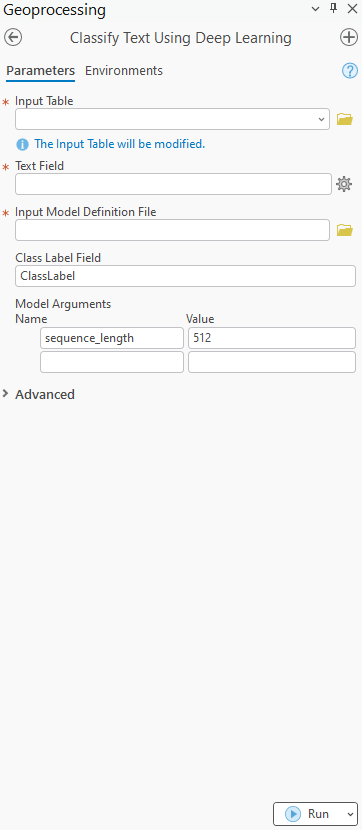

## Sample Input Table

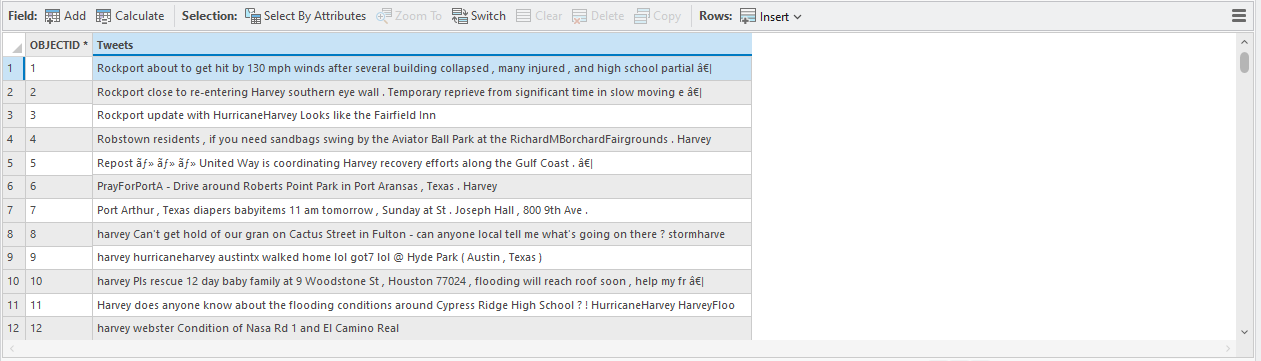

### After Extension file loading

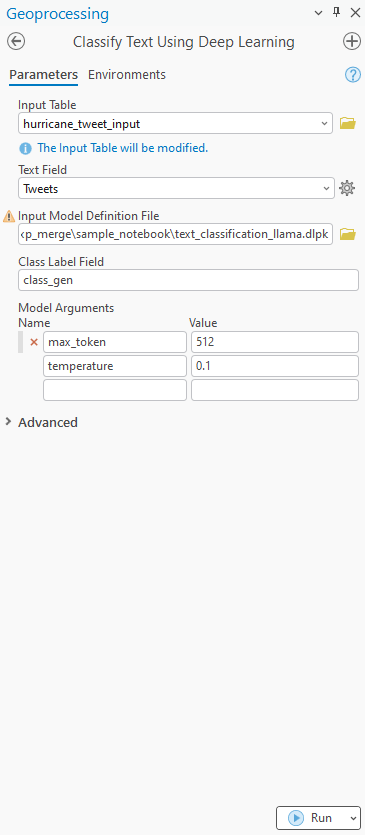

## Sample Output Table

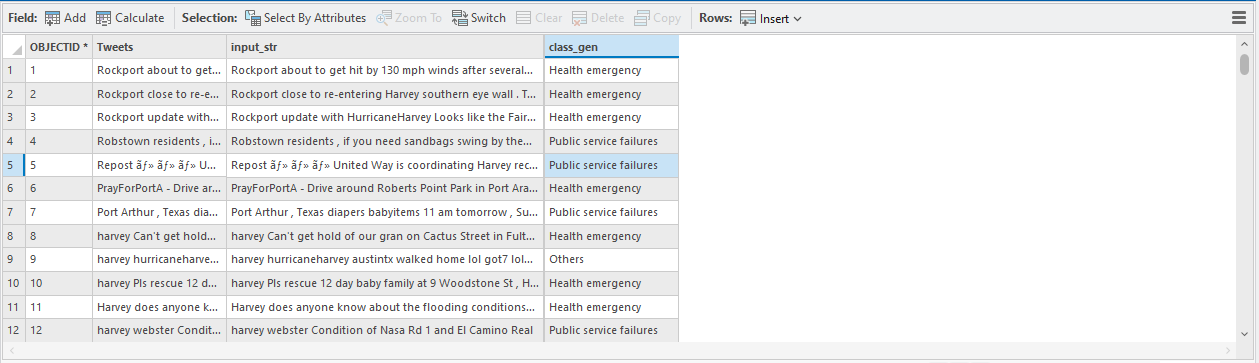

## Conclusion

Utilizing the HarveyTweet Dataset, we successfully identified and classified tweets into critical categories, such as public services and health-related information. Below are the results from the sample inputs.

In [ ]:

| Tweets                                                                                                                     | Predicted Class         |
|----------------------------------------------------------------------------------------------------------------------------|-------------------------|
| Rockport about to get hit by 130 mph winds after several building collapsed , many injured , and high school partial â€¦   | Health emergency        |
| Rockport close to re-entering Harvey southern eye wall . Temporary reprieve from significant time in slow moving e â€¦     | Health emergency        |
| Rockport update with HurricaneHarvey Looks like the Fairfield Inn                                                          | Health emergency        |
| Robstown residents , if you need sandbags swing by the Aviator Ball Park at the RichardMBorchardFairgrounds . Harvey       | Public service failures |
| Repost ãƒ» ãƒ» ãƒ» United Way is coordinating Harvey recovery efforts along the Gulf Coast . â€¦                           | Public service failures |
| PrayForPortA - Drive around Roberts Point Park in Port Aransas , Texas . Harvey                                            | Health emergency        |
| Port Arthur , Texas diapers babyitems 11 am tomorrow , Sunday at St . Joseph Hall , 800 9th Ave .                          | Public service failures |
| harvey Can't get hold of our gran on Cactus Street in Fulton - can anyone local tell me what's going on there ? stormharve | Health emergency        |
| harvey hurricaneharvey austintx walked home lol got7 lol @ Hyde Park ( Austin , Texas )                                    | Others                  |
| harvey Pls rescue 12 day baby family at 9 Woodstone St , Houston 77024 , flooding will reach roof soon , help my fr â€¦    | Health emergency        |
| Harvey does anyone know about the flooding conditions around Cypress Ridge High School ? ! HurricaneHarvey HarveyFloo      | Health emergency        |
| harvey webster Condition of Nasa Rd 1 and El Camino Real                                                                   | Public service failures |